In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import scale, robust_scale
from sklearn.linear_model import HuberRegressor, Ridge, LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, matthews_corrcoef
from sklearn.utils import shuffle

%matplotlib inline

# Read in data files, shortening column names and setting identifier data to type string 
Data = pd.read_csv('datasets/DEMOGRAPHICS.csv', usecols=['State_FIPS_Code', 'County_FIPS_Code', 'CHSI_County_Name', 'Strata_ID_Number',
                                                'Population_Size', 'White', 'Black', 'Native_American', 'Asian',
                                                'Hispanic'],
                   dtype={'State_FIPS_Code': str, 'County_FIPS_Code': str, 'Strata_ID_Number': str})

Data.rename(columns={'CHSI_County_Name': 'County', 'Strata_ID_Number': 'Strata', 'Population_Size': 'Population'}, inplace=True)


Birth = pd.read_csv('datasets/MEASURESOFBIRTHANDDEATH.csv', usecols=['State_FIPS_Code', 'County_FIPS_Code', 'Unmarried',
                                                            'Late_Care', 'LBW', 'VLBW', 'Under_18', 'Over_40'],
                   dtype={'State_FIPS_Code': str, 'County_FIPS_Code': str})

Vulnerable = pd.read_csv('datasets/VUNERABLEPOPSANDENVHEALTH.csv', usecols=['State_FIPS_Code', 'County_FIPS_Code', 'Major_Depression',
                                                                   'Recent_Drug_Use'],
                        dtype={'State_FIPS_Code': str, 'County_FIPS_Code': str})
Vulnerable.rename(columns={'Major_Depression': 'Depression', 'Recent_Drug_Use': 'Drugs'}, inplace=True)

Risks = pd.read_csv('datasets/RISKFACTORSANDACCESSTOCARE.csv', usecols =['State_FIPS_Code', 'County_FIPS_Code',
                                                                'Obesity', 'Smoker','High_Blood_Pres',
                                                                'Diabetes', 'Uninsured', 'Prim_Care_Phys_Rate',
                                                                'Community_Health_Center_Ind'],
                   dtype={'State_FIPS_Code': str, 'County_FIPS_Code': str})
Risks.rename(columns={'High_Blood_Pres': 'HBP', 'Prim_Care_Phys_Rate': 'Doctors',
                      'Community_Health_Center_Ind': 'Health_Centers'}, inplace=True)

Environment = pd.read_csv('datasets/EQI_RESULTS_2013JULY22.CSV', usecols=['stfips', 'air_EQI_22July2013',
                                                                 'water_EQI_22July2013', 'land_EQI_22July2013',
                                                                 'sociod_EQI_22July2013', 'built_EQI_22July2013'],
                          dtype={'stfips': str})
Environment.columns = ['FIPS', 'Air_EQI', 'Water_EQI', 'Land_EQI', 'Sociod_EQI', 'Built_EQI']

Economics = pd.read_csv('datasets/Unemployment.csv', usecols=['FIPS_Code', 'Unemployment_rate_2014', 'Median_Household_Income_2014'],
                       dtype={'FIPS_Code': str})
Economics.columns = ['FIPS', 'Unemployment', 'Income']

Education = pd.read_csv('datasets/Education.csv', usecols=['FIPS_Code', 'No_high_school_diploma', 'High_school_diploma_only',
                                                 'Some_college_or_associate_degree', 'Bachelor_or_higher'],
                       dtype={'FIPS_Code': str})
Education.columns = ['FIPS', '<HS_diploma', 'Diploma', 'Some_college', 'Bachelor+']

In [2]:
Data = pd.merge(Data, Birth, on=['State_FIPS_Code', 'County_FIPS_Code'])
Data = pd.merge(Data, Vulnerable, on=['State_FIPS_Code', 'County_FIPS_Code'])
Data = pd.merge(Data, Risks, on=['State_FIPS_Code', 'County_FIPS_Code'])

*Reformat the state code so that it is one or two (character) digits with no leading zeroes, and append this to the county code to produce a 4- or 5-character standardized identifier string for each county*

*I got the idea for the lambda expression from a Stack Overflow post: http://stackoverflow.com/questions/14059094/i-want-to-multiply-two-columns-in-a-pandas-dataframe-and-add-the-result-into-a-n*

In [3]:
Data['State_FIPS_Code'] = Data['State_FIPS_Code'].map(lambda x: x[1:] if x[0] == '0' else x)
Data['County_FIPS_Code'] = Data['State_FIPS_Code'] + Data['County_FIPS_Code']
Data.head()

,State_FIPS_Code,County_FIPS_Code,County,Strata,Population,White,Black,Native_American,Asian,Hispanic,...,Late_Care,Depression,Drugs,Obesity,HBP,Smoker,Diabetes,Uninsured,Doctors,Health_Centers
0,1,1001,Autauga,29,48612,80.7,17.3,0.5,0.6,1.7,...,12.9,2680,2394,24.5,29.1,26.6,14.2,5690,45.3,1
1,1,1003,Baldwin,16,162586,88.4,9.9,0.5,0.4,2.3,...,15.3,9354,7753,23.6,30.5,24.6,7.2,19798,67.0,1
2,1,1005,Barbour,51,28414,52.2,46.8,0.4,0.3,3.1,...,26.0,1618,1403,25.6,-1111.1,17.7,6.6,5126,45.8,1
3,1,1007,Bibb,42,21516,76.8,22.5,0.3,0.1,1.4,...,16.3,1218,1034,-1111.1,-1111.1,-1111.1,13.1,3315,41.8,1
4,1,1009,Blount,28,55725,97.1,1.5,0.5,0.2,6.3,...,16.7,3164,2675,24.2,-1111.1,23.6,8.4,8131,16.2,2


*Set all missing values to a number that cannot appear on its own in the data, then count how many for each feature.*


In [4]:
Data.replace(to_replace=[-1, -1111, -1111.1, -2, -2222, -2222.2], value=-9999.0, inplace=True)
(Data==-9999.0).sum()

State_FIPS_Code        0
County_FIPS_Code       0
County                 0
Strata                 0
Population             0
White                  0
Black                  0
Native_American        0
Asian                  0
Hispanic               0
LBW                   31
VLBW                 215
Under_18              79
Over_40              130
Unmarried              7
Late_Care            109
Depression             0
Drugs                  0
Obesity              917
HBP                 1619
Smoker               874
Diabetes             422
Uninsured              3
Doctors                0
Health_Centers         0
dtype: int64

*The Obesity, HBP and Smoker columns have too many missing values, so drop them. Also drop records with no LBW data, since this will be the primary target so should not be interpolated.*

In [5]:
Data.drop(['Obesity', 'HBP', 'Smoker'], axis=1, inplace=True)

In [6]:
Data = Data[Data['LBW']!=-9999.0]

In [7]:
Data[Data['Late_Care']==-9999.0]['State_FIPS_Code'].unique()

array(['42', '53'], dtype=object)

In [8]:
Data[Data['Diabetes']==-9999.0]['State_FIPS_Code'].unique()

array(['1', '2', '5', '6', '8', '12', '13', '16', '17', '18', '20', '21',
       '26', '27', '28', '29', '30', '31', '32', '35', '36', '37', '38',
       '39', '40', '41', '42', '45', '46', '47', '48', '49', '51', '53',
       '55'], dtype=object)

In [9]:
Data[Data['Diabetes']==-9999.0]['Strata'].unique()

array(['75', '71', '80', '78', '9', '86', '83', '17', '47', '77', '37',
       '88', '42', '51', '33', '81', '32', '58', '85', '40', '29', '79',
       '84', '87', '82', '74', '67', '69', '44', '66', '62', '41', '68',
       '39', '70', '50', '59', '60', '57', '55', '72', '54', '56', '64',
       '61', '76', '38', '43', '52', '48', '30', '28', '73', '26', '27',
       '65', '8', '34', '63'], dtype=object)

*All of the records missing data for little or no care during the first trimester are from two states -- Pennsylvania and Washington. This localization, combined with the fact that this factor has been found to be significant in previous research, makes interpolation seem a bad choice. These records represent less than 5% of the total, so they will be dropped for the initial features ranking and brought back in if Late_Care does not turn out to be significant. But this will be done after all other preprocessing is complete.*

*Diabetes, however, is a growing health problem that could be a significant factor here, and the records with missing data account for more than 12% of the total. These records are not localized geographically or by strata, and diabetes is a more generalized phenomenon compared to pregnancy care, which could be strongly affected by health care availability in a given area, so interpolation seems a better option.*

*First, however, the State_FIPS_Code column can be dropped and County_FIPS_Code can be renamed to FIPS, the same as the other databases. *

In [10]:
Data.drop('State_FIPS_Code', axis=1, inplace=True)
Data.rename(columns={'County_FIPS_Code': 'FIPS'}, inplace=True)

In [11]:
Environment[Environment.isnull().values.any(axis=1)].count()

FIPS          0
Air_EQI       0
Water_EQI     0
Land_EQI      0
Sociod_EQI    0
Built_EQI     0
dtype: int64

In [12]:
Environment.head()

,FIPS,Air_EQI,Water_EQI,Land_EQI,Sociod_EQI,Built_EQI
0,01001,0.955385,-1.109728,-0.706591,0.670436,-0.497301
1,01003,0.717964,-0.565911,-1.084299,0.553073,0.401585
2,01005,0.131007,-0.978090,-1.281470,-1.236294,0.048854
3,01007,0.065289,-0.968173,-0.827410,-0.600018,-1.290857
4,01009,0.402194,-0.718645,-0.622934,0.296509,-1.262740


In [13]:
Environment['FIPS'] = Environment['FIPS'].map(lambda x: x[1:] if x[0] == '0' else x) # Remove leading zeroes

In [14]:
Economics[Economics.isnull().values.any(axis=1)].count() # This dataset leaves missing values as null

FIPS            83
Unemployment    79
Income           1
dtype: int64

In [15]:
Economics.fillna(value=-9999, inplace=True)
(Economics==-9999.0).sum()

FIPS            10
Unemployment    14
Income          92
dtype: int64

In [16]:
Education[Education.isnull().values.any(axis=1)].count()


FIPS            10
<HS_diploma      0
Diploma          0
Some_college     0
Bachelor+        0
dtype: int64

In [17]:
Education.fillna(value=-9999.0, inplace=True)
(Education==-9999.0).sum()


FIPS             0
<HS_diploma     10
Diploma         10
Some_college    10
Bachelor+       10
dtype: int64

*Merge the datasets before further preprocessing, because some of the problematic records might be eliminated in the process.*

In [18]:
Data = pd.merge(Data, Economics, on=['FIPS'])
Data = pd.merge(Data, Education, on=['FIPS'])
Data = pd.merge(Data, Environment, on=['FIPS'])


In [19]:
(Data==-9999.0).sum()


FIPS                 0
County               0
Strata               0
Population           0
White                0
Black                0
Native_American      0
Asian                0
Hispanic             0
LBW                  0
VLBW               184
Under_18            51
Over_40            101
Unmarried            1
Late_Care          106
Depression           0
Drugs                0
Diabetes           392
Uninsured            1
Doctors              0
Health_Centers       0
Unemployment         4
Income               3
<HS_diploma          3
Diploma              3
Some_college         3
Bachelor+            3
Air_EQI              0
Water_EQI            0
Land_EQI             0
Sociod_EQI           0
Built_EQI            0
dtype: int64

*Three records are missing income and all education data (this was checked, not assumed), so drop these few records with the observation that all are in Alaska with high Native American populations by percentage and have low LBW.*

In [20]:
Data.drop((Data[Data['Income']==-9999.0]).index.values, inplace=True)

*Missing predictor data can now be interpolated.*

In [21]:
def interpolate(col, df=Data):
    '''Where data for a feature (col) is missing, replace it by averaging that feature's values from all other counties
    in the same strata that are not missing the data.'''
    for ix in df[df[col]==-9999.0].index.values:
        df.loc[ix, col] = df[(df['Strata']==df.loc[ix, 'Strata']) & (df[col]!=-9999.0)][col].mean()

In [22]:
interpolate('Under_18')
interpolate('Over_40')
interpolate('Unmarried')
interpolate('Diabetes')
interpolate('Uninsured')
interpolate('Unemployment')

In [23]:
(Data==-9999.0).sum()

FIPS                 0
County               0
Strata               0
Population           0
White                0
Black                0
Native_American      0
Asian                0
Hispanic             0
LBW                  0
VLBW               183
Under_18             0
Over_40              0
Unmarried            0
Late_Care          106
Depression           0
Drugs                0
Diabetes             0
Uninsured            0
Doctors              0
Health_Centers       0
Unemployment         0
Income               0
<HS_diploma          0
Diploma              0
Some_college         0
Bachelor+            0
Air_EQI              0
Water_EQI            0
Land_EQI             0
Sociod_EQI           0
Built_EQI            0
dtype: int64

*All the predictor variables now have values. But 'Depression', 'Drugs' and 'Uninsured' are counts and need to be divided by population (scaling will do the rest). Then separate the predictors from the targets, after removing the records with no Late_Care data and storing them for possible use later.* 

In [24]:
Data['Depression'] = Data['Depression'].divide(Data['Population'])
Data['Drugs'] = Data['Drugs'].divide(Data['Population'])
Data['Uninsured'] = Data['Uninsured'].divide(Data['Population'])

In [25]:
No_late_care = Data[Data['Late_Care']==-9999.0]
Data.drop(No_late_care.index.values, inplace=True)

In [26]:
cols = Data.columns.tolist()
targets = cols[9:11]
predictors = cols[4:9] + cols[11:]
predictors

['White',
 'Black',
 'Native_American',
 'Asian',
 'Hispanic',
 'Under_18',
 'Over_40',
 'Unmarried',
 'Late_Care',
 'Depression',
 'Drugs',
 'Diabetes',
 'Uninsured',
 'Doctors',
 'Health_Centers',
 'Unemployment',
 'Income',
 '<HS_diploma',
 'Diploma',
 'Some_college',
 'Bachelor+',
 'Air_EQI',
 'Water_EQI',
 'Land_EQI',
 'Sociod_EQI',
 'Built_EQI']

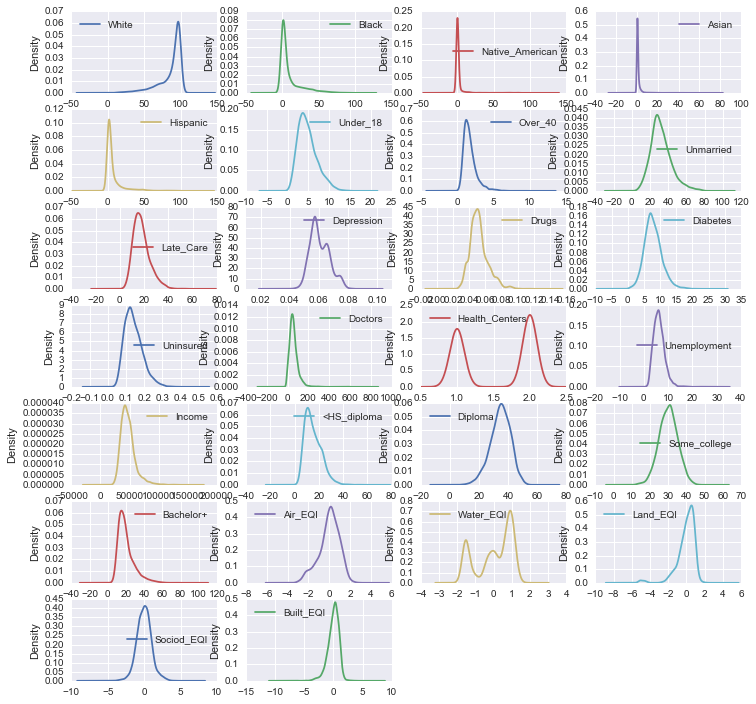

In [27]:
# Plot the distribution of values for each feature
Data[predictors].plot.kde(subplots=True, sharex=False, sharey=False, layout=(7,4), figsize=(12,12))
plt.savefig('images/predictors.png')

*Since the ultimate aim is to evaluate the relative strength of the predictors rather than to predict values for the dependent variable, any data transformations that were not uniform across all the variables would bias the results. There is no systemic pattern in the data that could be addressed with a single transformation, so no transformations will be applied.*

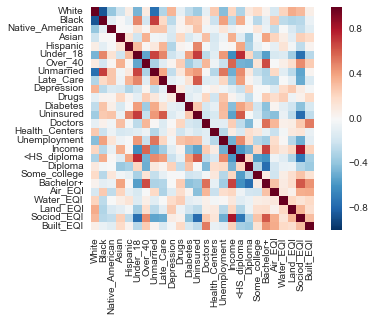

In [28]:
# Plot a heat map showing pairwise correlations among the data
corrs = Data[predictors].corr()
map = sb.heatmap(corrs, square=True)
map.figure.savefig('images/heatmap.png')

In [29]:
# Compute Variance Inflation Scores for all the features
VIF_scores = []
pred_array = Data[predictors].as_matrix()
for i, x in enumerate(predictors):
    VIF_scores.append( (x, vif(pred_array, i)) )
del(pred_array)
VIF_scores

[('White', 11755.003407766962),
 ('Black', 444.32971672157515),
 ('Native_American', 96.522327011182355),
 ('Asian', 20.916471217603519),
 ('Hispanic', 3.9653706848865471),
 ('Under_18', 28.016868771201072),
 ('Over_40', 11.596677939124017),
 ('Unmarried', 55.038023675834772),
 ('Late_Care', 14.581286646620189),
 ('Depression', 141.05708351985729),
 ('Drugs', 34.917467502097232),
 ('Diabetes', 13.647047124824104),
 ('Uninsured', 48.521086196991597),
 ('Doctors', 5.0399775855822533),
 ('Health_Centers', 13.696090940122636),
 ('Unemployment', 18.866116663815991),
 ('Income', 93.548209498695684),
 ('<HS_diploma', 466.59642027396819),
 ('Diploma', 2015.2805242469967),
 ('Some_college', 1410.4251227197119),
 ('Bachelor+', 770.20451021755605),
 ('Air_EQI', 3.0541633594068154),
 ('Water_EQI', 1.3229797588087562),
 ('Land_EQI', 1.4718112726293691),
 ('Sociod_EQI', 8.7567150440466577),
 ('Built_EQI', 1.8805452684194028)]

*Drop 'White' because it is strongly correlated with all the other races and has the highest VIF score among them. Similarly, drop 'Diploma', 'Some-college' and 'Bachelor+' because the education data is highly correlated, and '<HS_diploma' has the lowest VIF score and potentially has the greatest value as an actionable predictor. Drop 'Sociod_EQI' because it has strong correlations with other predictors and is a complex predictor that would be hard to interpret. 'Unmarried' and 'Depression' also have high VIF scores, the first being highly correlated with several other predictors and the second being a statistic that would be hard to reliably determine for local populations with varied access to and utilization of mental health services.*

In [30]:
drop_list = ['White', 'Diploma', 'Some_college', 'Bachelor+',
             'Sociod_EQI', 'Unmarried', 'Depression']
pred_array = Data[predictors].drop(drop_list, axis=1).as_matrix()
VIF_scores = []
for i, x in enumerate([p for p in predictors if p not in drop_list]):
    VIF_scores.append( (x, vif(pred_array, i)) )
VIF_scores


[('Black', 2.9642979088714605),
 ('Native_American', 1.4304194099145957),
 ('Asian', 1.6479975953038783),
 ('Hispanic', 2.6201798023508136),
 ('Under_18', 22.462550998049295),
 ('Over_40', 10.483319499423937),
 ('Late_Care', 13.692424169865959),
 ('Drugs', 26.854742504627588),
 ('Diabetes', 11.955779129645125),
 ('Uninsured', 33.849989346315077),
 ('Doctors', 4.327903239894658),
 ('Health_Centers', 12.123873927780357),
 ('Unemployment', 17.111916636038377),
 ('Income', 23.454583256563691),
 ('<HS_diploma', 20.018598492484056),
 ('Air_EQI', 2.3843599181540687),
 ('Water_EQI', 1.2609520084594874),
 ('Land_EQI', 1.3137769557797168),
 ('Built_EQI', 1.6946755252023331)]

*Even though several VIF scores are still high, keep these predictors to run through a Random Forest algorithm for feature selection. So long as the number of features selected at random for each tree is not too large, the algorithm should be able to select the most useful of potentially collinear variables. Interacting terms might also be introduced to try and improve performance if necessary.* 

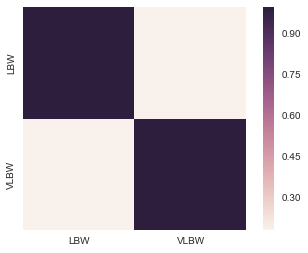

In [31]:
# Plot heat map showing how correlated the two potential target variables are with each other. 
target_corrs = Data[targets].corr()
map = sb.heatmap(target_corrs, square=True)
map.figure.savefig('images/heatmap2.png')

*LBW and VLBW exhibit little correlation, so much it is worth investigating both.*

In [32]:
# Set FIPS as the index, and remove County and Strata, which are no longer needed.
Data.drop(['County', 'Strata'], axis=1, inplace=True)
Data.set_index('FIPS', inplace=True)
X = Data.drop(drop_list, axis=1)

In [33]:
print X.describe()

         Population        Black  Native_American        Asian     Hispanic  \
count  2.999000e+03  2999.000000      2999.000000  2999.000000  2999.000000   
mean   9.256095e+04     9.294898         1.927943     1.096465     7.067089   
std    3.085536e+05    14.775846         7.531878     2.607526    12.544733   
min    5.770000e+02     0.000000         0.000000     0.000000     0.000000   
25%    1.129600e+04     0.500000         0.200000     0.300000     1.200000   
50%    2.477800e+04     2.200000         0.400000     0.500000     2.300000   
75%    6.258250e+04    10.800000         0.850000     1.000000     6.400000   
max    9.935475e+06    86.000000        93.400000    55.100000    97.500000   

               LBW         VLBW     Under_18      Over_40    Late_Care  \
count  2999.000000  2999.000000  2999.000000  2999.000000  2999.000000   
mean      7.607302  -598.841847     4.786012     1.737852    17.765855   
std       1.851881  2375.725738     2.288550     0.901261     6.76

*The stats confirm that there are no negative values aside from VLBW, which will be handled later, and the EQI predictors, which have been normalized with zero mean. So all the N/A values have been dealt with. Since interacting features might be created, negative values must be brought above zero before this is done to avoid the problem of negative values multiplying together to give the same result as positive values. First drop the Population column, which will be used as a sample weight vector, and check for outliers.*

In [34]:
targets_plus_pop = targets + ['Population']
X.drop(targets_plus_pop, axis=1, inplace=True)
Stats = X.describe()
IQR = Stats.loc['75%'] - Stats.loc['25%']
Lower = Stats.loc['25%'] - 1.5 * IQR
Upper = Stats.loc['75%'] + 1.5 * IQR
Outliers = ((X < Lower) | (X > Upper)).sum().sum()
Outliers

2524

In [35]:
Outliers = ((X < Lower) | (X > Upper)).sum(axis = 1) >= 2
Outliers.sum()

637

In [36]:
Outliers = ((X < Lower) | (X > Upper)).sum(axis = 1) >= 3
Outliers.sum()

246

*The number of outliers is huge compared to the number of records in the dataset, but the number of records with 3 or more outlier values is only 220, or 7% of the dataset, so remove these.*

In [37]:
Data_outliers = Data[Outliers]  # save for possible future use
Data.drop(Data_outliers.index.values, inplace=True)
X.drop(Data_outliers.index.values, inplace=True)

In [38]:
def rfRegress(clf, X, y):
    '''Auxiliary function to run the random forest regressions, and display the results and feature rankings'''
    clf.fit(X, y)
    final = clf.best_estimator_
    print 'Holdout score: ', clf.best_score_
    print clf.best_params_, '\n'
    importance = final.feature_importances_
    feature_rank = zip(X.columns, importance)
    feature_rank.sort(key=lambda tup: tup[1], reverse=True)
    for f, r in feature_rank:
        print('{:10.10}: {:.5f}'.format(f, r))
    return final, feature_rank       

In [39]:
y_lbw = Data['LBW']
lbw_weights = Data['Population'] / 1000.0
features = X.columns
tuned_params = {'n_estimators': np.arange(150, 760, 75), 'max_depth': np.arange(7, 14)}
clf = GridSearchCV(RandomForestRegressor(max_features=7, bootstrap=False, random_state=57), param_grid=tuned_params,
                  fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=5, shuffle=True))
final, feature_rank = rfRegress(clf, X, y_lbw)
print '\n', 'Training score: ', final.score(X, y_lbw, sample_weight=lbw_weights) 

Holdout score:  0.662959174194
{'n_estimators': 750, 'max_depth': 12} 

Black     : 0.42839
Under_18  : 0.12254
Income    : 0.05263
Land_EQI  : 0.04688
Uninsured : 0.03688
Hispanic  : 0.03559
Native_Ame: 0.03429
<HS_diplom: 0.03036
Diabetes  : 0.02995
Air_EQI   : 0.02862
Doctors   : 0.02733
Water_EQI : 0.02425
Drugs     : 0.02414
Unemployme: 0.02105
Asian     : 0.01481
Over_40   : 0.01423
Late_Care : 0.01364
Built_EQI : 0.01258
Health_Cen: 0.00182

Training score:  0.980700023937


*The large difference between the holdout score and the score on the database as a whole shows strong overfitting of the training data, so reduce tree depth and number of features.*

In [40]:
tuned_params = {'n_estimators': np.arange(350, 460, 25)}
clf = GridSearchCV(RandomForestRegressor(max_features=7, max_depth=7, bootstrap=False, random_state=57), param_grid=tuned_params,
                  fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=5, shuffle=True))
final, feature_rank = rfRegress(clf, X, y_lbw)
print '\n', 'Training score: ', final.score(X, y_lbw, sample_weight=lbw_weights) 

Holdout score:  0.636161842355
{'n_estimators': 450} 

Black     : 0.48641
Under_18  : 0.13493
Income    : 0.05031
Land_EQI  : 0.04538
Native_Ame: 0.03360
Uninsured : 0.03220
Hispanic  : 0.02863
Diabetes  : 0.02756
<HS_diplom: 0.02649
Doctors   : 0.02232
Air_EQI   : 0.02042
Water_EQI : 0.01951
Drugs     : 0.01878
Unemployme: 0.01632
Asian     : 0.01248
Over_40   : 0.00908
Late_Care : 0.00848
Built_EQI : 0.00612
Health_Cen: 0.00100

Training score:  0.880542010225


*Reducing the tree depth did result in less overfitting, but it also reduced the holdout and training scores. Alternatively, reduce the number of cv folds to train on smaller subsets of data.*

In [41]:
tuned_params = {}
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_features=7, max_depth=12, bootstrap=False, random_state=57),
                   param_grid=tuned_params, fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X, y_lbw)
print '\n', 'Training score: ', final.score(X, y_lbw, sample_weight=lbw_weights) 

Holdout score:  0.663084125251
{} 

Black     : 0.42483
Under_18  : 0.12431
Income    : 0.05079
Land_EQI  : 0.04724
Hispanic  : 0.03659
Uninsured : 0.03613
Native_Ame: 0.03397
<HS_diplom: 0.03108
Diabetes  : 0.02998
Air_EQI   : 0.02923
Doctors   : 0.02707
Water_EQI : 0.02509
Drugs     : 0.02476
Unemployme: 0.02164
Asian     : 0.01448
Over_40   : 0.01413
Late_Care : 0.01391
Built_EQI : 0.01298
Health_Cen: 0.00180

Training score:  0.980756901365


In [42]:
tuned_params = {}
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_features=7, max_depth=12, bootstrap=False, random_state=777),
                   param_grid=tuned_params, fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X, y_lbw)
print '\n', 'Training score: ', final.score(X, y_lbw, sample_weight=lbw_weights) 

Holdout score:  0.660456947162
{} 

Black     : 0.42838
Under_18  : 0.12157
Income    : 0.06041
Land_EQI  : 0.04614
Uninsured : 0.03751
Hispanic  : 0.03582
Native_Ame: 0.03291
Air_EQI   : 0.02951
<HS_diplom: 0.02869
Diabetes  : 0.02720
Doctors   : 0.02631
Drugs     : 0.02496
Water_EQI : 0.02347
Unemployme: 0.02089
Over_40   : 0.01430
Late_Care : 0.01369
Asian     : 0.01364
Built_EQI : 0.01272
Health_Cen: 0.00189

Training score:  0.980857168634


In [43]:
lbw_features = [f for f,s in feature_rank[:13]] # top 13 features

*A fourth trial used a different randon seed for the regressor, although allowing KFold to generate its own seed should have produced different randomized splits on the other trials. Since the three-fold split performed as well as or better than the five-fold, it is being used for cross-validation because uses less computing resources. All of the trials produced the same 13 highest-ranking features, though with variance in the positions, so select these. Now look at prediction results for very low birth weight (VLBW) and for predictors without racial groups, since race is immutable.*

In [44]:
races = ['Black', 'Native_American', 'Hispanic', 'Asian']
X_lbw_nr = X.drop(races, axis=1) # The tag 'nr' is used to label data with no racial features.

no_VLBW = (Data[Data['VLBW']==-9999.0]).index.values
X_vlbw = X.drop(no_VLBW)
y_vlbw = Data['VLBW'].drop(no_VLBW)
vlbw_weights = lbw_weights.drop(no_VLBW)
X_vlbw_nr = X_lbw_nr.drop(no_VLBW)

In [45]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=57), param_grid={},
                  fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X_lbw_nr, y_lbw)

Holdout score:  0.563931884428
{} 

Under_18  : 0.22803
Doctors   : 0.09624
Air_EQI   : 0.09608
Land_EQI  : 0.08859
Income    : 0.08641
Water_EQI : 0.07223
Uninsured : 0.06527
Unemployme: 0.05673
Drugs     : 0.05176
Diabetes  : 0.04347
<HS_diplom: 0.04148
Late_Care : 0.02768
Built_EQI : 0.02075
Over_40   : 0.02061
Health_Cen: 0.00466


In [46]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=75), param_grid={},
                  fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X_lbw_nr, y_lbw)

Holdout score:  0.554729442888
{} 

Under_18  : 0.22642
Air_EQI   : 0.09606
Doctors   : 0.09421
Income    : 0.09405
Land_EQI  : 0.09297
Water_EQI : 0.06792
Uninsured : 0.06439
Unemployme: 0.05420
Drugs     : 0.05295
<HS_diplom: 0.04304
Diabetes  : 0.03917
Late_Care : 0.02892
Built_EQI : 0.02096
Over_40   : 0.02000
Health_Cen: 0.00474


In [47]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=99), param_grid={},
                  fit_params={'sample_weight': lbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X_lbw_nr, y_lbw)

Holdout score:  0.559681548794
{} 

Under_18  : 0.22181
Income    : 0.09795
Air_EQI   : 0.09689
Doctors   : 0.09411
Land_EQI  : 0.08836
Water_EQI : 0.06946
Uninsured : 0.06587
Unemployme: 0.05560
Drugs     : 0.05361
Diabetes  : 0.04345
<HS_diplom: 0.04044
Late_Care : 0.02792
Built_EQI : 0.02040
Over_40   : 0.01958
Health_Cen: 0.00455


*Performance went down without race in the feature set, and the ranking changed significantly. But the bottom 4 features remained at the bottom ('Asian' not being in this feature set). Run the algorithm on the VLBW data.*


In [48]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=57), param_grid={},
                   fit_params={'sample_weight': vlbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X_vlbw, y_vlbw)

Holdout score:  0.547854518781
{} 

Black     : 0.51533
Under_18  : 0.05601
Native_Ame: 0.04916
Air_EQI   : 0.04814
Income    : 0.04310
Doctors   : 0.03728
Uninsured : 0.03604
Unemployme: 0.03429
Diabetes  : 0.02292
Hispanic  : 0.02243
Drugs     : 0.02031
Water_EQI : 0.02020
Land_EQI  : 0.01853
<HS_diplom: 0.01807
Late_Care : 0.01776
Asian     : 0.01418
Built_EQI : 0.01248
Over_40   : 0.01121
Health_Cen: 0.00256


In [49]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=75), param_grid={},
                   fit_params={'sample_weight': vlbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X_vlbw, y_vlbw)

Holdout score:  0.552981155407
{} 

Black     : 0.51220
Under_18  : 0.05964
Air_EQI   : 0.04883
Income    : 0.04715
Native_Ame: 0.04425
Doctors   : 0.03739
Uninsured : 0.03591
Unemployme: 0.03240
Hispanic  : 0.02472
Diabetes  : 0.02233
Land_EQI  : 0.02024
Drugs     : 0.01993
Water_EQI : 0.01896
Late_Care : 0.01876
<HS_diplom: 0.01782
Asian     : 0.01401
Built_EQI : 0.01213
Over_40   : 0.01081
Health_Cen: 0.00251


In [50]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=99), param_grid={},
                   fit_params={'sample_weight': vlbw_weights.values}, cv=KFold(n_splits=3, shuffle=True))
final, feature_rank = rfRegress(clf, X_vlbw, y_vlbw)

Holdout score:  0.549213738055
{} 

Black     : 0.52386
Under_18  : 0.05163
Income    : 0.04837
Air_EQI   : 0.04606
Native_Ame: 0.04378
Uninsured : 0.03837
Doctors   : 0.03616
Unemployme: 0.03202
Hispanic  : 0.02447
Diabetes  : 0.02301
Drugs     : 0.02109
Water_EQI : 0.01885
Land_EQI  : 0.01883
Late_Care : 0.01817
<HS_diplom: 0.01617
Asian     : 0.01361
Built_EQI : 0.01215
Over_40   : 0.01112
Health_Cen: 0.00228


In [51]:
lbw_features.append('Unemployment')

*There was very little change in the ranking, except that 'Unemployment' moved up as the 8th-ranked feature. In order to simplify further analysis, add this to lbw_features and use these for both LBW and VLBW data sets. '<HS_diploma' did move into the bottom-dwelling features, but keep this since it was significantly higher in LBW runs.*

In [52]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=350, max_depth=12, max_features=7, bootstrap=False,
                                         random_state=57), param_grid={},
                   fit_params={'sample_weight': vlbw_weights.values}, cv=KFold(n_splits=5, shuffle=True))
final, feature_rank = rfRegress(clf, X_vlbw_nr, y_vlbw)

Holdout score:  0.416876680836
{} 

Air_EQI   : 0.15075
Under_18  : 0.12596
Doctors   : 0.10879
Income    : 0.09721
Unemployme: 0.08274
Uninsured : 0.07701
Land_EQI  : 0.06887
Water_EQI : 0.06351
Drugs     : 0.04979
Diabetes  : 0.04600
<HS_diplom: 0.04188
Late_Care : 0.03637
Built_EQI : 0.02635
Over_40   : 0.02102
Health_Cen: 0.00376


In [53]:
nr_features = [f for f in lbw_features if f not in ['Black', 'Hispanic', 'Native_American']]

*The rankings are the same for LBW and VLBW with the racial predictors removed, so again, only one feature set is needed for both, and it turns out to be the same as lbw_features with the 3 racial features removed. Interestingly, Late_Care does not appear in the top 10 in any of the rankings, so the records missing this data that were dropped from the data set earlier can be restored.*

In [54]:
No_late_care.drop(['County', 'Strata'], axis=1, inplace=True)
No_late_care.set_index('FIPS', inplace=True)
Outliers = ((No_late_care < Lower) | (No_late_care > Upper)).sum(axis = 1) >= 3
No_late_outliers = No_late_care[Outliers]  # keep for possible later use
No_late_care.drop(No_late_outliers.index.values, inplace=True)
y_lbw = y_lbw.append(No_late_care['LBW'])
lbw_weights = lbw_weights.append(No_late_care['Population'] / 1000)

# remove any records with no VLBW data from the VLBW targets and weights
no_vlbw_additional = No_late_care[No_late_care['VLBW']==-9999.0].index.values
y_vlbw = y_vlbw.append(No_late_care.drop(no_vlbw_additional)['VLBW'])
vlbw_weights = vlbw_weights.append(No_late_care.drop(no_vlbw_additional)['Population'] / 1000)

# One data set can be preprocessed and all the needed sets recreated from it after
X_lbw = X.append(No_late_care.drop((drop_list + targets_plus_pop), axis=1))
X = X.append(No_late_care.drop((drop_list + targets_plus_pop), axis=1)) # X is kept as the complete final data set in case a transformation needs to be undone
no_VLBW = np.concatenate([no_VLBW, no_vlbw_additional])


/Users/vince/anaconda/envs/ML/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/vince/anaconda/envs/ML/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


*NOTE: The warning is a false one. This is a known issue with pandas.*

In [55]:
# Before proceeding, drop the features that were not selected for any of the data sets.
X_lbw.drop(['Health_Centers', 'Over_40', 'Built_EQI', 'Late_Care', 'Asian'], axis=1, inplace=True)
X_lbw.describe()

,Black,Native_American,Hispanic,Under_18,Drugs,Diabetes,Uninsured,Doctors,Unemployment,Income,<HS_diploma,Air_EQI,Water_EQI,Land_EQI
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,8.780527,1.395852,5.618102,4.684123,0.051423,7.853485,0.136887,55.516626,6.142214,46505.161336,14.819684,0.028840,0.011714,0.045087
std,14.036475,4.661276,9.616176,2.147580,0.010423,2.576766,0.043768,39.789044,2.047773,10640.097751,6.249718,0.922210,0.995184,0.848352
min,0.000000,0.000000,0.000000,0.500000,0.028051,0.600000,0.035900,0.000000,1.200000,23047.000000,1.900000,-2.989472,-1.641266,-4.979651
25%,0.500000,0.200000,1.100000,3.100000,0.044473,6.100000,0.103850,31.000000,4.600000,39089.000000,10.000000,-0.452802,-1.063553,-0.358862
50%,2.000000,0.400000,2.100000,4.300000,0.050401,7.600000,0.130828,50.300000,6.000000,45158.000000,13.500000,0.130730,0.242306,0.207918
75%,10.300000,0.800000,5.200000,5.900000,0.055968,9.400000,0.165655,72.200000,7.500000,52003.000000,19.000000,0.686084,0.898596,0.638329
max,86.000000,72.800000,89.200000,14.400000,0.101231,20.800000,0.293471,571.100000,16.000000,122641.000000,44.200000,2.346921,1.478177,2.094526


*A potential method to achieve a better fit to the data is to create interacting features, but negative- or zero-valued data would be a problem. For instance, the product of two negative values would be the same as two positive values of the same magnitude, and any value multiplied by Zero. So add a constant to all values in any feature with negative or zero values. This will not affect the results, because adding a constant does not change the variance.*

In [56]:
stats = X_lbw.describe()
neg_values = [c for c in stats.columns if stats.loc['min', c] < 0]
for c in neg_values: # add constant to bring all values above zero
    X_lbw.loc[:, c] = X_lbw[c] - np.floor(stats.loc['min', c])
    
zero_values = [c for c in stats.columns if stats.loc['min', c] == 0.0]
for c in zero_values: # add constant to bring all values above zero
    X_lbw.loc[:, c] = X_lbw[c] + 0.1  

*Scikit scalers return numpy matrices, not dataframes. Columns cannot be dropped by name, so scale each set. Because of the large number of outliers, generate sets with robust scaling as well as with standard scaling for use with a Hubert regressor, which handles outliers on its own.*


In [57]:
X_vlbw = X_lbw.drop(no_VLBW)
X_lbw_nr = X[nr_features]
X_vlbw_nr = X_vlbw[nr_features]

X_standard_lbw = scale(X)
X_standard_vlbw = scale(X_vlbw)
X_standard_lbw_nr = scale(X_lbw_nr)
X_standard_vlbw_nr = scale(X_vlbw_nr)

X_robust_lbw = robust_scale(X)
X_robust_vlbw = robust_scale(X_vlbw)
X_robust_lbw_nr = robust_scale(X_lbw_nr)
X_robust_vlbw_nr = robust_scale(X_vlbw_nr)

In [58]:
def huber_trial(rand, start, end, numsteps, X=X_standard_lbw, y=y_lbw, weights=lbw_weights, features=lbw_features):
    '''Generate train and test subsets, and run a Huber regression on them. The input parameters control the bounds
    for GridSearchCV to use in optimizing the regression's epsilon parameter and allow the regression to be run on
    different datasets with different sample weights.'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
    shuffled_train = y_train.index.values
    shuffled_test = y_test.index.values
    test_weights = weights.loc[shuffled_test]
    train_weights = weights.loc[shuffled_train]
    tuned_params = {'epsilon': np.linspace(start, end, num=numsteps, endpoint=True)}
    clf = GridSearchCV(HuberRegressor(), param_grid=tuned_params, fit_params={'sample_weight': train_weights.values},
                       cv=KFold(n_splits=3))
    clf.fit(X_train, y_train)
    final = clf.best_estimator_
    print 'Holdout score: ', clf.best_score_
    print(clf.best_params_)
    print 'Test score: ', final.score(X_test, y_test, sample_weight=test_weights)
    feature_rank = zip(features, final.coef_)
    feature_rank.sort(key=lambda tup: tup[1], reverse=True)
    for f, r in feature_rank:
        print('{:16.16}: {:.5f}'.format(f, r))       

In [59]:
huber_trial(675, 8.0, 14.0, 13)

Holdout score:  0.583406642776
{'epsilon': 11.0}
Test score:  0.616534027056
Black           : 0.85723
Uninsured       : 0.45765
Doctors         : 0.14945
<HS_diploma     : 0.14093
Diabetes        : 0.12921
Native_American : 0.05221
Air_EQI         : 0.04540
Unemployment    : -0.01485
Water_EQI       : -0.02666
Hispanic        : -0.04984
Drugs           : -0.07447
Under_18        : -0.11028
Income          : -0.12262
Land_EQI        : -0.15263


In [60]:
huber_trial(19, 1.3, 2.8, 16)

Holdout score:  0.5755631218
{'epsilon': 2.2000000000000002}
Test score:  0.708782836869
Black           : 0.80308
Uninsured       : 0.55140
Doctors         : 0.17977
Diabetes        : 0.14643
<HS_diploma     : 0.11958
Native_American : 0.03067
Air_EQI         : 0.02954
Unemployment    : 0.02900
Water_EQI       : 0.00342
Income          : -0.07132
Hispanic        : -0.08657
Drugs           : -0.10171
Under_18        : -0.10671
Land_EQI        : -0.21956


In [61]:
final = huber_trial(2007, 2.0, 5.0, 16)

Holdout score:  0.581797559837
{'epsilon': 3.7999999999999998}
Test score:  0.636856036126
Black           : 0.83924
Uninsured       : 0.53387
Diabetes        : 0.17134
Doctors         : 0.14276
<HS_diploma     : 0.12999
Native_American : 0.05936
Unemployment    : 0.05731
Air_EQI         : 0.05469
Water_EQI       : 0.01346
Hispanic        : -0.08500
Drugs           : -0.09277
Income          : -0.10542
Under_18        : -0.10900
Land_EQI        : -0.15659


In [62]:
# Generate train and test sets using robust scaling for Ridge regression
def ridge_trial(rand, start, end, numsteps, X=X_robust_lbw, y=y_lbw, weights=lbw_weights, features=lbw_features):
    '''Generate train and test subsets, and run a ridge regression on them. The input parameters control the bounds
    for GridSearchCV to use in optimizing the regression's alpha parameter and allow the regression to be run on
    different datasets with different sample weights.'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
    shuffled_train = y_train.index.values
    shuffled_test = y_test.index.values
    test_weights = weights.loc[shuffled_test]
    train_weights = weights.loc[shuffled_train]
    tuned_params = {'alpha': np.logspace(start, end, num=numsteps)}
    clf = GridSearchCV(Ridge(), param_grid=tuned_params, fit_params={'sample_weight': train_weights.values},
                       cv=KFold(n_splits=3))
    clf.fit(X_train, y_train)
    final = clf.best_estimator_
    print 'Holdout score: ', clf.best_score_
    print(clf.best_params_)
    print 'Test score: ', final.score(X_test, y_test, sample_weight=test_weights)
    feature_rank = zip(lbw_features, final.coef_)
    feature_rank.sort(key=lambda tup: tup[1], reverse=True)
    for f, r in feature_rank:
        print('{:16.16}: {:.5f}'.format(f, r))      

In [63]:
ridge_trial(675, -3.0, 4.0, 15)

Holdout score:  0.58380505944
{'alpha': 1000.0}
Test score:  0.615799163324
Black           : 0.60316
Uninsured       : 0.56151
<HS_diploma     : 0.17880
Diabetes        : 0.17604
Doctors         : 0.15612
Air_EQI         : 0.04701
Native_American : 0.00024
Under_18        : -0.01391
Unemployment    : -0.02351
Water_EQI       : -0.03105
Income          : -0.04952
Hispanic        : -0.06269
Land_EQI        : -0.06313
Drugs           : -0.14842


In [64]:
ridge_trial(19, 2.0, 5.0, 13)

Holdout score:  0.579462189685
{'alpha': 5623.4132519034911}
Test score:  0.713754108774
Black           : 0.58724
Uninsured       : 0.55392
Diabetes        : 0.19854
Doctors         : 0.17183
<HS_diploma     : 0.12793
Air_EQI         : 0.03588
Unemployment    : 0.01955
Water_EQI       : 0.00403
Native_American : 0.00016
Under_18        : -0.01340
Income          : -0.02644
Land_EQI        : -0.08833
Hispanic        : -0.12079
Drugs           : -0.18828


In [65]:
final = ridge_trial(2007, 3.0, 4.0, 11)

Holdout score:  0.582548821571
{'alpha': 1995.2623149688789}
Test score:  0.635580584406
Uninsured       : 0.61687
Black           : 0.59802
Diabetes        : 0.23197
<HS_diploma     : 0.15751
Doctors         : 0.14679
Air_EQI         : 0.05732
Unemployment    : 0.05516
Water_EQI       : 0.01825
Native_American : 0.00028
Under_18        : -0.01373
Income          : -0.04346
Land_EQI        : -0.06483
Hispanic        : -0.10155
Drugs           : -0.18170


*Neither regression produced very good results, but the positive feature rankings were fairly consistent, with the same top 2 features, then the same next 3 relatively closely bunched in most of the trials, and then another bunch of 3 with coefficients closer to 0. The Huber rankings, however, were more consistent with each other.*

In [66]:
huber_trial(675, 6.0, 14.0, 13, X=X_standard_vlbw, y=y_vlbw, weights=vlbw_weights)

Holdout score:  0.507602300347
{'epsilon': 12.0}
Test score:  0.667243741079
Black           : 0.30684
Land_EQI        : 0.08882
Drugs           : 0.07913
Hispanic        : 0.03259
Air_EQI         : 0.02617
Uninsured       : 0.01406
Doctors         : 0.00890
<HS_diploma     : 0.00412
Water_EQI       : -0.00059
Under_18        : -0.01444
Diabetes        : -0.01723
Unemployment    : -0.02204
Native_American : -0.02337
Income          : -0.03898


In [67]:
huber_trial(19, 6.0, 14.0, 17, X=X_standard_vlbw, y=y_vlbw, weights=vlbw_weights)

Holdout score:  0.502271826085
{'epsilon': 12.5}
Test score:  0.710064991332
Black           : 0.31966
Land_EQI        : 0.07262
Drugs           : 0.06144
Hispanic        : 0.03812
Air_EQI         : 0.02368
Uninsured       : 0.01610
<HS_diploma     : 0.01220
Doctors         : 0.01192
Water_EQI       : 0.00112
Unemployment    : -0.00425
Under_18        : -0.01717
Diabetes        : -0.02072
Native_American : -0.03501
Income          : -0.03729


In [68]:
ridge_trial(675, 3.0, 5.0, 15, X=X_robust_vlbw, y=y_vlbw, weights=vlbw_weights)

Holdout score:  0.523658472055
{'alpha': 19306.977288832495}
Test score:  0.683617756021
Black           : 0.21273
Drugs           : 0.07759
Land_EQI        : 0.06843
Hispanic        : 0.03883
Air_EQI         : 0.03577
Doctors         : 0.01834
<HS_diploma     : 0.01645
Uninsured       : 0.00663
Native_American : 0.00371
Under_18        : -0.00309
Water_EQI       : -0.00362
Income          : -0.01972
Diabetes        : -0.02447
Unemployment    : -0.02527


In [69]:
ridge_trial(19, 3.5, 5.0, 16, X=X_robust_vlbw, y=y_vlbw, weights=vlbw_weights)

Holdout score:  0.517064333227
{'alpha': 19952.623149688789}
Test score:  0.716593787358
Black           : 0.21651
Drugs           : 0.06603
Land_EQI        : 0.05915
Hispanic        : 0.04244
Air_EQI         : 0.03192
<HS_diploma     : 0.02275
Doctors         : 0.02049
Uninsured       : 0.00906
Water_EQI       : -0.00240
Native_American : -0.00302
Under_18        : -0.00363
Unemployment    : -0.01001
Income          : -0.02034
Diabetes        : -0.02374


*The grid search produced epsilon values above 12 for the Hubert regressor, and alpha values around 20,000 for the ridge regression. The high penalty coefficients combined with low feature coefficients show the algorithms are struggling to achieve good fits. Next try the data set with no racial features.*


In [70]:
huber_trial(675, 6.0, 14.0, 11, X=X_standard_lbw_nr, features=nr_features)

Holdout score:  0.357699970675
{'epsilon': 9.1999999999999993}
Test score:  0.378078970665
Under_18        : 1.22913
Air_EQI         : 0.54914
Doctors         : 0.28781
Unemployment    : 0.22577
Diabetes        : 0.19234
Drugs           : -0.05514
Income          : -0.06639
Water_EQI       : -0.18638
Uninsured       : -0.21070
Land_EQI        : -0.23733
<HS_diploma     : -0.29331


In [71]:
huber_trial(19, 6.0, 14.0, 17, X=X_standard_lbw_nr, features=nr_features)

Holdout score:  0.3622266063
{'epsilon': 11.5}
Test score:  0.494460208856
Under_18        : 1.36083
Air_EQI         : 0.48763
Doctors         : 0.28430
Unemployment    : 0.26315
Diabetes        : 0.14087
Income          : 0.01689
Drugs           : -0.04165
Water_EQI       : -0.15988
Land_EQI        : -0.20033
Uninsured       : -0.21950
<HS_diploma     : -0.33547


In [72]:
huber_trial(675, 6.0, 14.0, 11, X=X_standard_vlbw_nr, y=y_vlbw, weights=vlbw_weights, features=nr_features)

Holdout score:  0.173068481594
{'epsilon': 10.800000000000001}
Test score:  0.23880721721
Under_18        : 0.31080
Air_EQI         : 0.18182
Unemployment    : 0.11372
Doctors         : 0.08039
Diabetes        : 0.03168
Drugs           : -0.01044
Income          : -0.01396
Water_EQI       : -0.03049
Land_EQI        : -0.06290
Uninsured       : -0.06318
<HS_diploma     : -0.10220


*None of the regressions achieved a good score, but the best resuts were obtained with the LBW set. Try expanding the feature set.* 

In [73]:
def expand(df):
    '''Creates interaction features by multiplying each original column in a dataframe by every other and storing
    the result in a new column named by hyphenating the first 8 letters of the names of the parent columns.'''
    cols = df.columns.tolist()
    expanded = df.copy()
    while len(cols) >= 1:
        col = cols.pop(0)
        for c in cols:
            name = col[:8]+'-'+c[:8]
            expanded[name] = df[col] * df[c]
    return expanded           

In [74]:
expanded = expand(X_lbw)
expanded_features = expanded.columns
huber_trial(19, 2.0, 4.0, 11, X=scale(expanded), features=expanded_features)

Holdout score:  0.593779818619
{'epsilon': 4.0}
Test score:  0.672341818529
<HS_dipl-Air_EQI: 1.02486
Black-Drugs     : 0.77319
Under_18-Drugs  : 0.71698
Unemploy-<HS_dip: 0.71254
Diabetes-Air_EQI: 0.69486
Unemploy-Air_EQI: 0.65125
Black-Uninsure  : 0.64475
Black           : 0.62741
Uninsured       : 0.62688
Drugs-Income    : 0.47249
Black-Land_EQI  : 0.46184
Uninsure-Income : 0.43888
Under_18-Income : 0.43361
Drugs           : 0.41238
Unemploy-Water_E: 0.36777
Unemployment    : 0.35358
Air_EQI         : 0.34253
Diabetes-<HS_dip: 0.34060
Drugs-Water_EQ  : 0.31136
Native_A-Uninsur: 0.31043
Under_18-Land_EQ: 0.28695
Diabetes-Water_E: 0.27960
Income-Land_EQI : 0.27903
<HS_diploma     : 0.27304
Native_A-Water_E: 0.26694
Income-Water_EQ : 0.25381
Hispanic-Uninsur: 0.23534
Diabetes-Land_EQ: 0.23317
Under_18        : 0.19458
Hispanic-Doctors: 0.18952
Doctors-Land_EQI: 0.18849
Hispanic-Under_1: 0.18315
Hispanic-Water_E: 0.17608
Native_A-<HS_dip: 0.17182
Black-Doctors   : 0.17089
Doctors-Water_

*Using the interaction features does not improve the accuracy of the model and makes interpretation of the results much more difficult, with many features having comparable coefficients. Some combinations reveal puzzling interactions, such as individually high positively ranked features together producing highly negative features (e.g. 'Black-Air_EQI') that might be worth investigating (in this case, is LBW much higher in rural areas with large African-American populations than in urban areas with large African-american populations). As a safety check, run a regression with population as the only predictor to make sure the various features are not just decorating an underlying dynamic of LBW correlating with population, for instance being higher the more urban (populated) an area is.* 

In [75]:
X_pop = lbw_weights.values.reshape(-1, 1)
huber_trial(19, 3.0, 9.0, 11, X=scale(X_pop), features=[])

Holdout score:  -0.0169184700784
{'epsilon': 3.0}
Test score:  -0.0464321967491


*Population density might be a better choice.*

In [76]:
Density = pd.read_csv('datasets/DEMOGRAPHICS.csv', usecols=['State_FIPS_Code', 'County_FIPS_Code', 'Population_Density'],
                   dtype={'State_FIPS_Code': str, 'County_FIPS_Code': str, 'Population_Density': np.float64})
Density['State_FIPS_Code'] = Density['State_FIPS_Code'].map(lambda x: x[1:] if x[0] == '0' else x)
Density['County_FIPS_Code'] = Density['State_FIPS_Code'] + Density['County_FIPS_Code']
Density.drop('State_FIPS_Code', axis=1, inplace=True)
Density.rename(columns={'County_FIPS_Code': 'FIPS'}, inplace=True)
Density.set_index('FIPS', inplace=True)
Density.replace(to_replace=[-1, -1111, -1111.1, -2, -2222, -2222.2], value=-9999.0, inplace=True)

# Find and remove records that were dropped when the data was processed
absent = [i for i in Density.index.values if i not in y_lbw.index.values]
Density.drop(absent, inplace=True)

In [77]:
X_density = Density.values.reshape(-1, 1)
huber_trial(19, 3.0, 9.0, 11, X=scale(X_density), features=[])

Holdout score:  -0.000796463017732
{'epsilon': 3.0}
Test score:  0.0576442152896


*A simple correlation between population and LBW can be ruled out. But turning the regression into a classification problem could achieve better results than the regression did.*

In [78]:
mcc_scorer = make_scorer(matthews_corrcoef)

def logistic_trial(rand, threshold, start, end, numsteps, X=X_robust_lbw, y=y_lbw, weights=lbw_weights,
                   features=lbw_features, display=True, collect=False):
    '''Generate train and test subsets, and run a logistic regression on them. The input parameters provide the random
    seed for the split algorithm and the threshold for classifying LBW values as high; control the bounds for
    GridSearchCV to use in optimizing the regression's C parameter as well as whether output is displayed or data
    is collected; and allow the regression to be run on different datasets with different sample weights.'''
    global coll_ix  # for use with collect parameter flag to accumulate coefficients and scores over multiple runs
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
    shuffled_train = y_train.index.values
    shuffled_test = y_test.index.values
    test_weights = weights.loc[shuffled_test]
    train_weights = weights.loc[shuffled_train]
    y_train_logit = y_train > threshold
    y_test_logit = y_test > threshold
    tuned_params = {'penalty': ['l1', 'l2'], 'C': np.logspace(start, end, num=numsteps, endpoint=True)}
    clf = GridSearchCV(LogisticRegression(), param_grid=tuned_params, cv=5,
                       fit_params={'sample_weight': train_weights.values}, scoring=mcc_scorer)
    clf.fit(X_train, y_train_logit)
    final = clf.best_estimator_
    if display:  # display output can be turned off when accumulating coefficients over multiple runs
        print 'Holdout score: ', clf.best_score_
        print(clf.best_params_)
    calculated = final.predict(X_test)
    mcc = matthews_corrcoef(calculated, y_test_logit, sample_weight=test_weights)
    auc = roc_auc_score(y_test_logit, calculated, average=None)
    if display:
        print 'Test score: ', mcc
        print 'AUC score: ', auc
    importance = final.coef_[0]
    if collect:
        coll_ix += 1
        collected.loc[coll_ix] = np.append(importance, auc)
    feature_rank = zip(features, importance)
    feature_rank.sort(key=lambda tup: tup[1], reverse=True)
    if display:
        for f, r in feature_rank:
            print('{:11.10}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))
    return final

In [79]:
thresh = y_lbw.mean()
final = logistic_trial(675, thresh, -4.0, -2.0, 9)

Holdout score:  0.588801195737
{'penalty': 'l1', 'C': 0.001}
Test score:  0.694503791352
AUC score:  0.823625587574
Black      :  2.21192  OR: 9.13 
Uninsured  :  0.75352  OR: 2.12 
Diabetes   :  0.48331  OR: 1.62 
Doctors    :  0.20538  OR: 1.23 
Air_EQI    :  0.06916  OR: 1.07 
Native_Ame :  0.00015  OR: 1.00 
Hispanic   :  0.00000  OR: 1.00 
<HS_diplom :  0.00000  OR: 1.00 
Drugs      :  0.00000  OR: 1.00 
Water_EQI  :  0.00000  OR: 1.00 
Land_EQI   : -0.00880  OR: 0.99 
Under_18   : -0.03354  OR: 0.97 
Unemployme : -0.22274  OR: 0.80 
Income     : -0.34456  OR: 0.71 


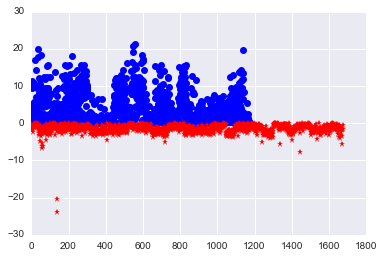

In [80]:
# Calculate and plot residuals from the logistic regression decision function
residuals = final.decision_function(X_robust_lbw)
predictions = final.predict(X_robust_lbw)
pos = residuals[predictions]
neg = residuals[np.invert(predictions)]

plt.plot(pos, 'bo', neg, 'r*')
plt.savefig('images/residuals1.png')

In [81]:
thresh = y_lbw.mean() + .5 * y_lbw.std()
final = logistic_trial(675, thresh, -4.0, -2.0, 9)

Holdout score:  0.622055981528
{'penalty': 'l1', 'C': 0.0031622776601683794}
Test score:  0.639658375613
AUC score:  0.806379259162
Black      :  1.73857  OR: 5.69 
Diabetes   :  0.73196  OR: 2.08 
Uninsured  :  0.42956  OR: 1.54 
Doctors    :  0.39424  OR: 1.48 
<HS_diplom :  0.25985  OR: 1.30 
Air_EQI    :  0.23909  OR: 1.27 
Native_Ame :  0.00064  OR: 1.00 
Water_EQI  :  0.00000  OR: 1.00 
Hispanic   : -0.01208  OR: 0.99 
Under_18   : -0.05012  OR: 0.95 
Income     : -0.14775  OR: 0.86 
Drugs      : -0.22296  OR: 0.80 
Land_EQI   : -0.23663  OR: 0.79 
Unemployme : -0.55163  OR: 0.58 


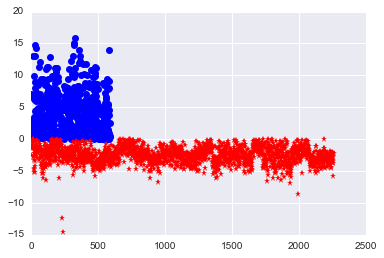

In [82]:
residuals = final.decision_function(X_robust_lbw)
predictions = final.predict(X_robust_lbw)
pos = residuals[predictions]
neg = residuals[np.invert(predictions)]

plt.plot(pos, 'bo', neg, 'r*')
plt.savefig('images/residuals2.png')

In [83]:
# Shuffle the data columns and rerun the regression to check for stability.
cols = X_lbw.columns.tolist()
x = pd.Series(cols)
shuffle_list = x.sample(n=len(cols), random_state=876)
X_shuffled = X_lbw[shuffle_list]
X_robust_shuffled = robust_scale(X_shuffled)
thresh = y_lbw.mean()
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_robust_shuffled, features=shuffle_list)

Holdout score:  0.555104314409
{'penalty': 'l1', 'C': 0.001}
Test score:  0.653748256065
AUC score:  0.815980737789
Under_18   :  1.86984  OR: 6.49 
Black      :  1.68402  OR: 5.39 
Air_EQI    :  0.28157  OR: 1.33 
Diabetes   :  0.20079  OR: 1.22 
Doctors    :  0.02072  OR: 1.02 
Uninsured  :  0.00000  OR: 1.00 
Drugs      :  0.00000  OR: 1.00 
<HS_diplom : -0.01543  OR: 0.98 
Water_EQI  : -0.05331  OR: 0.95 
Native_Ame : -0.05556  OR: 0.95 
Hispanic   : -0.15698  OR: 0.85 
Land_EQI   : -0.29217  OR: 0.75 
Unemployme : -0.34056  OR: 0.71 
Income     : -0.34277  OR: 0.71 


*Shuffling the database columns produced significantly different scores, with the coefficient of one of the features, 'Under_18', changing from slightly negative to +1.87, the highest positive ranking. Clearly the rankings are unreliable. Try logistic regression on the dataset with no racial features.*

In [84]:
thresh = y_lbw.mean()
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features)

Holdout score:  0.496998106073
{'penalty': 'l1', 'C': 0.0031622776601683794}
Test score:  0.564432306713
AUC score:  0.772717402412
Under_18   :  2.87515  OR:17.73 
Air_EQI    :  1.55732  OR: 4.75 
Doctors    :  0.26399  OR: 1.30 
Diabetes   :  0.22752  OR: 1.26 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.05257  OR: 0.95 
Income     : -0.28563  OR: 0.75 
Water_EQI  : -0.44163  OR: 0.64 
Uninsured  : -0.58975  OR: 0.55 
<HS_diplom : -0.70170  OR: 0.50 
Land_EQI   : -0.89268  OR: 0.41 


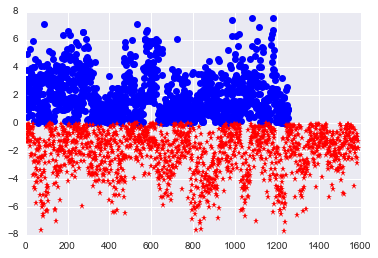

In [85]:
residuals = final.decision_function(X_robust_lbw_nr)
predictions = final.predict(X_robust_lbw_nr)
pos = residuals[predictions]
neg = residuals[np.invert(predictions)]

plt.plot(pos, 'bo', neg, 'r*')
plt.savefig('images/residuals3.png')

In [86]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features)

Holdout score:  0.509123093402
{'penalty': 'l1', 'C': 0.001}
Test score:  0.584604652551
AUC score:  0.74556631418
Under_18   :  2.45167  OR:11.61 
Air_EQI    :  1.18192  OR: 3.26 
Doctors    :  0.27267  OR: 1.31 
Diabetes   :  0.11484  OR: 1.12 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.02731  OR: 0.97 
Income     : -0.17904  OR: 0.84 
Water_EQI  : -0.35307  OR: 0.70 
Uninsured  : -0.39696  OR: 0.67 
<HS_diplom : -0.58297  OR: 0.56 
Land_EQI   : -0.85503  OR: 0.43 


In [87]:
thresh = y_lbw.mean() + .5 * y_lbw.std()
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features)

Holdout score:  0.486764471085
{'penalty': 'l2', 'C': 0.001}
Test score:  0.49856242791
AUC score:  0.703668721416
Under_18   :  1.83662  OR: 6.28 
Unemployme :  0.56318  OR: 1.76 
Air_EQI    :  0.50927  OR: 1.66 
Doctors    :  0.49772  OR: 1.64 
Diabetes   :  0.33672  OR: 1.40 
Land_EQI   :  0.00684  OR: 1.01 
Drugs      : -0.01674  OR: 0.98 
Water_EQI  : -0.30170  OR: 0.74 
Income     : -0.46714  OR: 0.63 
<HS_diplom : -0.52908  OR: 0.59 
Uninsured  : -0.54557  OR: 0.58 


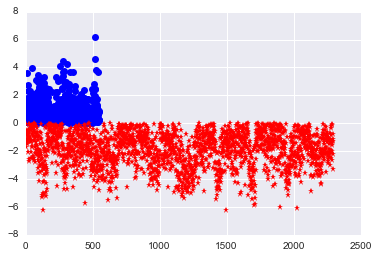

In [88]:
residuals = final.decision_function(X_robust_lbw_nr)
predictions = final.predict(X_robust_lbw_nr)
pos = residuals[predictions]
neg = residuals[np.invert(predictions)]

plt.plot(pos, 'bo', neg, 'r*')
plt.savefig('images/residuals4.png')

In [89]:
thresh = y_lbw.mean()
final = logistic_trial(2007, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features)

Holdout score:  0.501550734156
{'penalty': 'l1', 'C': 0.001}
Test score:  0.545976340611
AUC score:  0.771788563334
Under_18   :  2.41301  OR:11.17 
Air_EQI    :  1.13460  OR: 3.11 
Diabetes   :  0.21551  OR: 1.24 
Doctors    :  0.18890  OR: 1.21 
Drugs      :  0.00000  OR: 1.00 
Unemployme :  0.00000  OR: 1.00 
Uninsured  : -0.17685  OR: 0.84 
Water_EQI  : -0.25521  OR: 0.77 
Income     : -0.26949  OR: 0.76 
<HS_diplom : -0.80138  OR: 0.45 
Land_EQI   : -0.87728  OR: 0.42 


In [90]:
cols = X_lbw_nr.columns.tolist()
x = pd.Series(cols)
shuffle_list_nr = x.sample(n=len(cols), random_state=2007)
X_shuffled = X_lbw_nr[shuffle_list_nr]
X_robust_nr_shuffled = robust_scale(X_shuffled)
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_robust_nr_shuffled, features=shuffle_list_nr)

Holdout score:  0.509123093402
{'penalty': 'l1', 'C': 0.001}
Test score:  0.584604652551
AUC score:  0.74556631418
Under_18   :  2.45118  OR:11.60 
Air_EQI    :  1.18154  OR: 3.26 
Doctors    :  0.27280  OR: 1.31 
Diabetes   :  0.11481  OR: 1.12 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.02737  OR: 0.97 
Income     : -0.17913  OR: 0.84 
Water_EQI  : -0.35302  OR: 0.70 
Uninsured  : -0.39699  OR: 0.67 
<HS_diplom : -0.58263  OR: 0.56 
Land_EQI   : -0.85498  OR: 0.43 


In [91]:
cols = X_lbw_nr.columns.tolist()
x = pd.Series(cols)
shuffle_list_nr = x.sample(n=len(cols), random_state=876)
X_shuffled = X_lbw_nr[shuffle_list_nr]
X_robust_nr_shuffled = robust_scale(X_shuffled)
final = logistic_trial(2007, thresh, -4.0, -2.0, 9, X=X_robust_nr_shuffled, features=shuffle_list_nr)

Holdout score:  0.501550734156
{'penalty': 'l1', 'C': 0.001}
Test score:  0.545976340611
AUC score:  0.771788563334
Under_18   :  2.41304  OR:11.17 
Air_EQI    :  1.13477  OR: 3.11 
Diabetes   :  0.21557  OR: 1.24 
Doctors    :  0.18880  OR: 1.21 
Drugs      :  0.00000  OR: 1.00 
Unemployme :  0.00000  OR: 1.00 
Uninsured  : -0.17690  OR: 0.84 
Water_EQI  : -0.25523  OR: 0.77 
Income     : -0.26950  OR: 0.76 
<HS_diplom : -0.80149  OR: 0.45 
Land_EQI   : -0.87729  OR: 0.42 


*The results with the shuffled data are identical to the earlier regressions. Check to make sure the columns actually were shuffled.*

In [92]:
print cols
print shuffle_list_nr

['Under_18', 'Income', 'Land_EQI', 'Uninsured', 'Air_EQI', '<HS_diploma', 'Diabetes', 'Doctors', 'Drugs', 'Water_EQI', 'Unemployment']
7          Doctors
8            Drugs
3        Uninsured
10    Unemployment
6         Diabetes
9        Water_EQI
4          Air_EQI
1           Income
0         Under_18
5      <HS_diploma
2         Land_EQI
dtype: object


*As an alternative approach, exclude the data with the largest residuals from the training data.*

In [93]:
pred = final.decision_function(X_robust_lbw_nr) # Use the decision function from the last run, with an AUC of 0.77
reduced_X = X_robust_lbw_nr[(pred > -2) & (pred < 3)]
reduced_y = y_lbw[(pred > -2) & (pred < 3)]
reduced_weights = lbw_weights[(pred > -2) & (pred < 3)]

In [94]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=reduced_X, y = reduced_y, weights = reduced_weights, features=nr_features)

Holdout score:  0.503146021451
{'penalty': 'l2', 'C': 0.0017782794100389228}
Test score:  0.47646504426
AUC score:  0.725726299694
Under_18   :  2.18984  OR: 8.93 
Air_EQI    :  1.46667  OR: 4.33 
Doctors    :  0.44746  OR: 1.56 
Unemployme :  0.38906  OR: 1.48 
Diabetes   :  0.33289  OR: 1.39 
Drugs      : -0.30479  OR: 0.74 
Uninsured  : -0.38283  OR: 0.68 
Income     : -0.48894  OR: 0.61 
Water_EQI  : -0.63414  OR: 0.53 
Land_EQI   : -0.77092  OR: 0.46 
<HS_diplom : -0.90249  OR: 0.41 


*Training and testing on the data that had moderate residuals in the first iteration produced slightly worse performance. Test it on the held-out data with larger residuals.*

In [95]:
removed_X = X_robust_lbw_nr[(pred <= -2) | (pred >= 3)]
removed_y = y_lbw[(pred <= -2) | (pred >= 3)]
removed_y_logit = removed_y > thresh
removed_weights = lbw_weights[(pred <= -2) | (pred >= 3)]

In [96]:
removed_pred = final.predict(removed_X)
print 'Test score: ', matthews_corrcoef(removed_pred, removed_y_logit, sample_weight=removed_weights)
print 'AUC score: ', roc_auc_score(removed_y_logit, removed_pred, average=None)

Test score:  0.616803169776
AUC score:  0.703415019434


*There is reason enough to try a 'mixed' approach that trains on the data with moderate residuals but cross-validates and tests on a full range of data. This requires a custom implementation that holds *

In [97]:
def mixed_logistic(rand, threshold=thresh, X_reduced=reduced_X, y_reduced=reduced_y, weights1=reduced_weights,
                   X_removed=removed_X, y_removed=removed_y, weights2=removed_weights, num_splits=3, features=nr_features,
                   display=True, collect=False):
    '''Adapt the earlier function used to run logistic regressions by holding out the data with larger residuals
    during the training and then bringing it back in for the cross-validation and test scoring.'''
    y1 = y_reduced > thresh
    # Reformat the scaled data array of moderate-residual records as a dataframe. The targets still are in a dataframe.
    X1 = pd.DataFrame(data=X_reduced, index=y1.index.values, columns=features, copy=True)
    # Shuffling and splitting the y indices is used to split the data, targets and weights into training and test sets. 
    train1 = np.array_split(shuffle(y1.index.values, random_state=rand), num_splits+1)
    test1 = train1[num_splits]
    # The high-residuals data also needs to be divided into the same number of equal splits 
    y2 = y_removed > thresh
    X2 = pd.DataFrame(data=X_removed, index=y2.index.values, columns=features, copy=True)
    train2 = np.array_split(shuffle(y2.index.values, random_state=rand), num_splits+1)
    test2 = train2[num_splits]
    auc = 0
    mcc = 0
    final = []
    clf = LogisticRegression(penalty='l1', C=0.001, random_state=rand)
    # Implement custom cross-validation
    for i in np.arange(num_splits):
        ix = [] # List ix will hold the indices for the moderate-residuals training set on each iteration of the loop.
        for j in (k for k in np.arange(num_splits) if k != i):
            ix.extend(train1[j]) # Concatenate the indices except the i-th split
        this_clf = clf.fit(X1.loc[ix], y1.loc[ix], sample_weight=weights1.loc[ix]) # Regress on the training set.
        # The i-th split of the moderate- and high-residuals sets are concatenated into the test set.
        X = pd.concat([X1.loc[train1[i]], X2.loc[train2[i]]]) 
        y = pd.concat([y1.loc[train1[i]], y2.loc[train2[i]]])
        weights = pd.concat([weights1.loc[train1[i]], weights2.loc[train2[i]]])
        # Performance on the test set is scored.
        calculated = this_clf.predict(X) 
        this_mcc = matthews_corrcoef(calculated, y, sample_weight=weights)
        this_auc = roc_auc_score(y, calculated, average=None)
        mcc = max(mcc, this_mcc)
        # If the current iteration produces the highest score so far, store the mcc, auc and clf (final) values.
        if mcc == this_mcc:
            auc = this_auc
            final = this_clf
    # The best-performing regression coefficients are used to score the combined held-out test data.
    X = pd.concat([X1.loc[test1], X2.loc[test2]])
    y = pd.concat([y1.loc[test1], y2.loc[test2]])
    weights = pd.concat([weights1.loc[test1], weights2.loc[test2]])
    calculated = final.predict(X)
    mcc = matthews_corrcoef(calculated, y, sample_weight=weights)
    auc = roc_auc_score(y, calculated, average=None)
    if display:
        print 'Test score: ', mcc
        print 'AUC score: ', auc
    importance = final.coef_[0]
    if collect:
        coll_ix += 1
        collected.loc[coll_ix] = np.append(importance, auc)
    feature_rank = zip(features, importance)
    feature_rank.sort(key=lambda tup: tup[1], reverse=True)
    if display:
        for f, r in feature_rank:
            print('{:11.10}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))
    return final

In [98]:
final = mixed_logistic(19)

Test score:  0.616828687959
AUC score:  0.779597696591
Under_18   :  1.26675  OR: 3.55 
Air_EQI    :  0.83668  OR: 2.31 
Doctors    :  0.29555  OR: 1.34 
Unemployme :  0.06598  OR: 1.07 
Diabetes   :  0.02925  OR: 1.03 
Uninsured  :  0.00000  OR: 1.00 
<HS_diplom :  0.00000  OR: 1.00 
Water_EQI  :  0.00000  OR: 1.00 
Drugs      : -0.26261  OR: 0.77 
Income     : -0.54874  OR: 0.58 
Land_EQI   : -0.58872  OR: 0.56 


In [99]:
final = mixed_logistic(2007)

Test score:  0.564016283306
AUC score:  0.737245060802
Under_18   :  1.69605  OR: 5.45 
Air_EQI    :  0.72853  OR: 2.07 
Doctors    :  0.34904  OR: 1.42 
Diabetes   :  0.00000  OR: 1.00 
Unemployme :  0.00000  OR: 1.00 
Water_EQI  : -0.13393  OR: 0.87 
Uninsured  : -0.14318  OR: 0.87 
Income     : -0.50974  OR: 0.60 
Drugs      : -0.54508  OR: 0.58 
<HS_diplom : -0.57654  OR: 0.56 
Land_EQI   : -0.80260  OR: 0.45 


In [100]:
final = mixed_logistic(555)

Test score:  0.602596177213
AUC score:  0.761041400256
Under_18   :  1.77737  OR: 5.91 
Air_EQI    :  0.65661  OR: 1.93 
Doctors    :  0.30126  OR: 1.35 
Diabetes   :  0.19616  OR: 1.22 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.22668  OR: 0.80 
Uninsured  : -0.23600  OR: 0.79 
Income     : -0.27435  OR: 0.76 
Water_EQI  : -0.47149  OR: 0.62 
<HS_diplom : -0.48280  OR: 0.62 
Land_EQI   : -0.79979  OR: 0.45 


In [101]:
final = mixed_logistic(777)

Test score:  0.532253803476
AUC score:  0.718304171198
Under_18   :  2.21362  OR: 9.15 
Air_EQI    :  0.82709  OR: 2.29 
Doctors    :  0.37175  OR: 1.45 
Diabetes   :  0.22007  OR: 1.25 
Unemployme :  0.18144  OR: 1.20 
Water_EQI  : -0.26208  OR: 0.77 
Income     : -0.32477  OR: 0.72 
Uninsured  : -0.37104  OR: 0.69 
Drugs      : -0.38968  OR: 0.68 
<HS_diplom : -0.46457  OR: 0.63 
Land_EQI   : -0.61879  OR: 0.54 


In [102]:
final = logistic_trial(555, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features)

Holdout score:  0.51767993352
{'penalty': 'l1', 'C': 0.001}
Test score:  0.639643604302
AUC score:  0.742528477779
Under_18   :  2.53182  OR:12.58 
Air_EQI    :  1.23870  OR: 3.45 
Doctors    :  0.19439  OR: 1.21 
Diabetes   :  0.13771  OR: 1.15 
Unemployme :  0.05709  OR: 1.06 
Drugs      : -0.03329  OR: 0.97 
Water_EQI  : -0.21731  OR: 0.80 
Income     : -0.25203  OR: 0.78 
Uninsured  : -0.28092  OR: 0.76 
<HS_diplom : -0.69288  OR: 0.50 
Land_EQI   : -0.77825  OR: 0.46 


In [103]:
final = logistic_trial(777, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features)

Holdout score:  0.495424463048
{'penalty': 'l2', 'C': 0.0017782794100389228}
Test score:  0.561970051798
AUC score:  0.743897122929
Under_18   :  2.32204  OR:10.20 
Air_EQI    :  1.30146  OR: 3.67 
Doctors    :  0.36642  OR: 1.44 
Unemployme :  0.27114  OR: 1.31 
Diabetes   :  0.21547  OR: 1.24 
Drugs      : -0.05401  OR: 0.95 
Uninsured  : -0.31663  OR: 0.73 
Income     : -0.47949  OR: 0.62 
Water_EQI  : -0.54477  OR: 0.58 
Land_EQI   : -0.80008  OR: 0.45 
<HS_diplom : -0.92191  OR: 0.40 


*The mixed approach does not produce significantly better results and is much more computationally intensive, so run logistic_trial a large number of times (300) and collect the results for analysis.*

In [104]:
collected = pd.DataFrame(columns=np.append(nr_features, 'auc'))
coll_ix = -1
for i in np.arange(300):
    rand = np.random.randint(1, 100001)
    final = logistic_trial(rand, thresh, -4.0, -2.0, 9, X=X_robust_lbw_nr, features=nr_features, display=False,
                           collect=True)

In [105]:
stats = collected.describe()
stats

,Under_18,Income,Land_EQI,Uninsured,Air_EQI,<HS_diploma,Diabetes,Doctors,Drugs,Water_EQI,Unemployment,auc
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2.303026,-0.288710,-0.842672,-0.259536,1.259533,-0.595841,0.190474,0.312881,-0.070082,-0.292124,0.102884,0.752743
std,0.364977,0.092878,0.096471,0.201725,0.226346,0.213566,0.084017,0.061000,0.064109,0.108369,0.113565,0.017149
min,1.210739,-0.538994,-1.154075,-0.709582,0.660472,-1.151082,0.000000,0.154539,-0.250254,-0.588329,-0.050298,0.708464
25%,2.008647,-0.350904,-0.908170,-0.380367,1.119229,-0.729852,0.124565,0.273135,-0.115615,-0.361672,0.000000,0.741331
50%,2.333054,-0.294624,-0.845392,-0.298281,1.219176,-0.599395,0.188902,0.312864,-0.061358,-0.298623,0.075045,0.751598
75%,2.524290,-0.227212,-0.788647,-0.204761,1.388017,-0.489384,0.253719,0.353096,-0.015685,-0.223515,0.179954,0.763810
max,3.306369,-0.057942,-0.543480,0.413227,2.022677,0.000000,0.378234,0.532834,0.111423,-0.018081,0.497941,0.796017


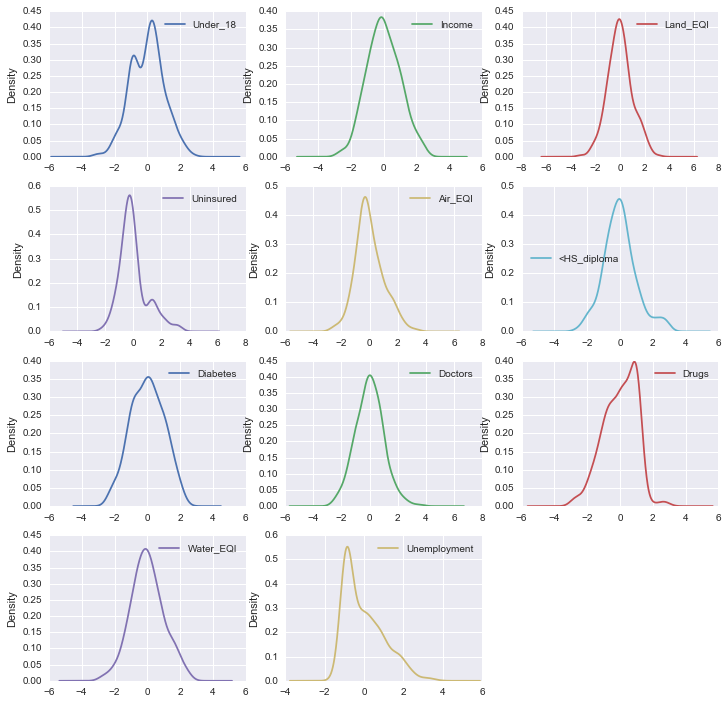

In [106]:
# Produce scaled distribution plots for the values of each feature coefficient
normalized = (collected.subtract(stats.loc['mean'])).divide(stats.loc['std'])
normalized[nr_features].plot.kde(subplots=True, sharex=False, sharey=False, layout=(4,3), figsize=(12,12))
plt.savefig('images/results.png')

*The feature values are all normally distributed. The data is not producing skewed results, so take the mean for each feature as the respective coefficient in the final model.*

In [107]:
importance = stats.loc['mean']
feature_rank = zip(nr_features, importance)
feature_rank.sort(key=lambda tup: tup[1], reverse=True)
for f, r in feature_rank:
    print('{:11.10}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))

Under_18   :  2.30303  OR:10.00 
Air_EQI    :  1.25953  OR: 3.52 
Doctors    :  0.31288  OR: 1.37 
Diabetes   :  0.19047  OR: 1.21 
Unemployme :  0.10288  OR: 1.11 
Drugs      : -0.07008  OR: 0.93 
Uninsured  : -0.25954  OR: 0.77 
Income     : -0.28871  OR: 0.75 
Water_EQI  : -0.29212  OR: 0.75 
<HS_diplom : -0.59584  OR: 0.55 
Land_EQI   : -0.84267  OR: 0.43 


In [108]:
# Check the VIF scores for the final model
pred_array = X_robust_lbw_nr
VIF_scores = []
for i, x in enumerate([p for p in nr_features]):
    VIF_scores.append( (x, vif(pred_array, i)) )
VIF_scores

[('Under_18', 3.3282858218363391),
 ('Income', 1.990544495668253),
 ('Land_EQI', 1.3646140766586585),
 ('Uninsured', 2.749897974450052),
 ('Air_EQI', 1.6922080413172913),
 ('<HS_diploma', 2.6892414072595194),
 ('Diabetes', 1.3136121837594941),
 ('Doctors', 1.1735189166029556),
 ('Drugs', 1.2906863992750506),
 ('Water_EQI', 1.1101589852794909),
 ('Unemployment', 2.028951850352505)]

*The VIF scores are very good. As a final check, run some regressions with some of the less and more significant features missing to see the effect on the results.*

In [109]:
Xframe = pd.DataFrame(data=X_robust_lbw_nr, index=y_lbw.values, columns=nr_features, copy=True)
X_try = Xframe.drop('Doctors', axis=1)
feat_try = [f for f in nr_features if f != 'Doctors']
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.4988165613
{'penalty': 'l2', 'C': 0.0005623413251903491}
Test score:  0.55051318686
AUC score:  0.772685469037
Under_18   :  1.61427  OR: 5.02 
Air_EQI    :  1.20399  OR: 3.33 
Diabetes   :  0.26739  OR: 1.31 
Drugs      : -0.12939  OR: 0.88 
Unemployme : -0.12984  OR: 0.88 
Uninsured  : -0.29878  OR: 0.74 
Water_EQI  : -0.34529  OR: 0.71 
<HS_diplom : -0.42435  OR: 0.65 
Income     : -0.44599  OR: 0.64 
Land_EQI   : -0.81031  OR: 0.44 


In [110]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.51259286198
{'penalty': 'l1', 'C': 0.001}
Test score:  0.525578236342
AUC score:  0.740208943814
Under_18   :  2.47703  OR:11.91 
Air_EQI    :  1.36924  OR: 3.93 
Diabetes   :  0.07321  OR: 1.08 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.00968  OR: 0.99 
Income     : -0.23262  OR: 0.79 
Uninsured  : -0.33275  OR: 0.72 
Water_EQI  : -0.35259  OR: 0.70 
<HS_diplom : -0.78016  OR: 0.46 
Land_EQI   : -0.85010  OR: 0.43 


In [111]:
X_try = Xframe.drop('Water_EQI', axis=1)
feat_try = [f for f in nr_features if f != 'Water_EQI']
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.502260191363
{'penalty': 'l1', 'C': 0.0031622776601683794}
Test score:  0.61011336561
AUC score:  0.771887134682
Under_18   :  2.81694  OR:16.73 
Air_EQI    :  1.53812  OR: 4.66 
Diabetes   :  0.26436  OR: 1.30 
Doctors    :  0.25416  OR: 1.29 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.10416  OR: 0.90 
Income     : -0.30211  OR: 0.74 
Uninsured  : -0.62577  OR: 0.53 
<HS_diplom : -0.73066  OR: 0.48 
Land_EQI   : -0.98658  OR: 0.37 


In [112]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.496331449812
{'penalty': 'l1', 'C': 0.001}
Test score:  0.594223246567
AUC score:  0.749821633329
Under_18   :  2.43226  OR:11.38 
Air_EQI    :  1.16301  OR: 3.20 
Doctors    :  0.27203  OR: 1.31 
Diabetes   :  0.15162  OR: 1.16 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.06441  OR: 0.94 
Income     : -0.19489  OR: 0.82 
Uninsured  : -0.42990  OR: 0.65 
<HS_diplom : -0.61474  OR: 0.54 
Land_EQI   : -0.90983  OR: 0.40 


In [113]:
X_try = Xframe.drop('Air_EQI', axis=1)
feat_try = [f for f in nr_features if f != 'Air_EQI']
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.427402789988
{'penalty': 'l1', 'C': 0.00017782794100389227}
Test score:  0.506675450697
AUC score:  0.748875945228
Under_18   :  1.00986  OR: 2.75 
Doctors    :  0.32191  OR: 1.38 
Diabetes   :  0.00558  OR: 1.01 
Uninsured  :  0.00000  OR: 1.00 
<HS_diplom :  0.00000  OR: 1.00 
Water_EQI  :  0.00000  OR: 1.00 
Unemployme :  0.00000  OR: 1.00 
Income     : -0.05545  OR: 0.95 
Drugs      : -0.09006  OR: 0.91 
Land_EQI   : -0.70884  OR: 0.49 


In [114]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.441053136805
{'penalty': 'l1', 'C': 0.00017782794100389227}
Test score:  0.486947185889
AUC score:  0.717836667091
Under_18   :  1.00269  OR: 2.73 
Doctors    :  0.32402  OR: 1.38 
Uninsured  :  0.00000  OR: 1.00 
<HS_diplom :  0.00000  OR: 1.00 
Diabetes   :  0.00000  OR: 1.00 
Water_EQI  :  0.00000  OR: 1.00 
Unemployme :  0.00000  OR: 1.00 
Income     : -0.01470  OR: 0.99 
Drugs      : -0.04110  OR: 0.96 
Land_EQI   : -0.70399  OR: 0.49 


In [115]:
X_try = Xframe.drop('Land_EQI', axis=1)
feat_try = [f for f in nr_features if f != 'Land_EQI']
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.477659952276
{'penalty': 'l1', 'C': 0.0005623413251903491}
Test score:  0.55542786113
AUC score:  0.766388207644
Under_18   :  2.28343  OR: 9.81 
Air_EQI    :  0.84823  OR: 2.34 
Doctors    :  0.24049  OR: 1.27 
Diabetes   :  0.13542  OR: 1.15 
Unemployme :  0.00000  OR: 1.00 
Drugs      : -0.20077  OR: 0.82 
Uninsured  : -0.29596  OR: 0.74 
Income     : -0.32730  OR: 0.72 
<HS_diplom : -0.46539  OR: 0.63 
Water_EQI  : -0.63300  OR: 0.53 


In [116]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.482383589624
{'penalty': 'l1', 'C': 0.001}
Test score:  0.472586062958
AUC score:  0.728863549497
Under_18   :  2.57614  OR:13.15 
Air_EQI    :  0.99339  OR: 2.70 
Doctors    :  0.29706  OR: 1.35 
Diabetes   :  0.14230  OR: 1.15 
Unemployme : -0.04217  OR: 0.96 
Drugs      : -0.14229  OR: 0.87 
Uninsured  : -0.21400  OR: 0.81 
Income     : -0.24378  OR: 0.78 
<HS_diplom : -0.65387  OR: 0.52 
Water_EQI  : -0.79942  OR: 0.45 


In [117]:
X_try = Xframe.drop('Under_18', axis=1)
feat_try = [f for f in nr_features if f != 'Under_18']
final = logistic_trial(675, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.437851067271
{'penalty': 'l1', 'C': 0.0017782794100389228}
Test score:  0.534379008097
AUC score:  0.765276926221
Air_EQI    :  1.01483  OR: 2.76 
Diabetes   :  0.47436  OR: 1.61 
Doctors    :  0.28584  OR: 1.33 
Uninsured  :  0.00000  OR: 1.00 
<HS_diplom :  0.00000  OR: 1.00 
Unemployme : -0.08488  OR: 0.92 
Drugs      : -0.26532  OR: 0.77 
Water_EQI  : -0.30555  OR: 0.74 
Income     : -0.83596  OR: 0.43 
Land_EQI   : -1.05750  OR: 0.35 


In [118]:
final = logistic_trial(19, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.442439615851
{'penalty': 'l1', 'C': 0.005623413251903491}
Test score:  0.459023898722
AUC score:  0.720193655243
Air_EQI    :  1.07412  OR: 2.93 
Diabetes   :  0.50648  OR: 1.66 
Doctors    :  0.31536  OR: 1.37 
Uninsured  :  0.00339  OR: 1.00 
<HS_diplom : -0.02287  OR: 0.98 
Unemployme : -0.18179  OR: 0.83 
Drugs      : -0.20144  OR: 0.82 
Water_EQI  : -0.39126  OR: 0.68 
Income     : -0.76512  OR: 0.47 
Land_EQI   : -1.12530  OR: 0.32 


In [119]:
final = logistic_trial(2007, thresh, -4.0, -2.0, 9, X=X_try, features=feat_try)

Holdout score:  0.434142578993
{'penalty': 'l1', 'C': 0.0005623413251903491}
Test score:  0.466949066955
AUC score:  0.754112925272
Air_EQI    :  0.64683  OR: 1.91 
Diabetes   :  0.36565  OR: 1.44 
Doctors    :  0.20418  OR: 1.23 
Uninsured  :  0.00000  OR: 1.00 
<HS_diplom :  0.00000  OR: 1.00 
Unemployme :  0.00000  OR: 1.00 
Water_EQI  : -0.09335  OR: 0.91 
Drugs      : -0.16951  OR: 0.84 
Income     : -0.73474  OR: 0.48 
Land_EQI   : -1.00734  OR: 0.37 


*Dropping the more significant features had a greater effect than dropping the less significant features, but the difference was not as much as expected.*